# Logistic modeling

The goal of this modeling phase is to create a baseline model to compare more complex archetectures against. Furthermore due to the size of the dataset testing new features on more complex models will be time consuming, as such testing their value on a simplier model will speed up the modeling process.

Goals: 
- Create a base line model
- Create and test engineered features

Data Preperation

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

In [2]:
import pandas as pd
import numpy as np

# Combine both datasets to allow for my own train/test split
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

df = pd.concat([train_df,test_df], ignore_index=True)


Basic data checks

In [3]:
print(df.columns)
print(df.dtypes)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_lon

In [8]:
# From earlier analysis we know that DE has a 100% fraud rate as such we will drop it from the dataset
df.drop(df[df['state'] == 'DE'].index, inplace=True)


In [9]:
print(df['merchant'].nunique())
print(df['state'].nunique())

693
50


Convert date to datetime objects

In [10]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
# Extract date (if you want to split/aggregate by day)
df['trans_date'] = df['trans_date_trans_time'].dt.date


From analysis we identified a common pattern in fraudulent transations was a small test payment was quickly followed by a larger transaction. As such 'time_since_last' the time since the last transaction and 'last_amt' the previous transaction amount are created 

In [11]:
df = df.sort_values(by=['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

# Compute time difference (in seconds) per card
df['time_since_last'] = df.groupby('cc_num')['unix_time'].diff()
# Fill NaN (first transaction per card has no "last")
df['time_since_last'] = df['time_since_last'].fillna(-1)

df['last_amt'] = df.groupby('cc_num')['amt'].shift(1)
# Fill NaN (for the first transaction of each card, where no "last" exists)
df['last_amt'] = df['last_amt'].fillna(0)

Sorting data and dropping irrelevant columns - note these features seemed insignificant in analysis and due to the size of the dataset were dropped

In [12]:
df = df.sort_values(by=['trans_date_trans_time']).reset_index(drop=True)
modeling_df1 = df.drop([
    'Unnamed: 0', 'merchant', 'first', 'last', 'street', 'city', 'state', 'zip', 
    'lat', 'long', 'city_pop', 'job', 'dob', 'gender',
    'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'time_since_last', 'last_amt'
], axis=1)

In [13]:
modeling_df1.dtypes

trans_date_trans_time    datetime64[ns]
cc_num                            int64
category                         object
amt                             float64
is_fraud                          int64
trans_hour                        int32
trans_date                       object
dtype: object

In [14]:
modeling_df1 = modeling_df1.drop(['cc_num', 'trans_date'], axis=1)

# Baseline Linear Regression
- Regression on variables initally hypothesised to be significant based on analysis and reaserch [amt, is_fraud, trans_hour, category], the dependent variable is_fraud is a binary feature where the value of 1 represents fraud

Train/test splits

In [15]:
# sort data to avoid leakage
modeling_df1 = modeling_df1.sort_values('trans_date_trans_time').reset_index(drop=True)

# 2) Time-based splits
split_idx = int(len(modeling_df1) * 0.80)
train_df = modeling_df1.iloc[:split_idx]
test_df  = modeling_df1.iloc[split_idx:]

drop_cols = ['is_fraud', 'trans_date_trans_time', 'trans_date', 'cc_num']
features = [col for col in modeling_df1.columns if col not in drop_cols]

y_train = train_df['is_fraud']
X_train = train_df[features]

y_test = test_df['is_fraud']
X_test = test_df[features]

## Pipeline + model

In [16]:
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first'))
])

cat_features = ['category']
num_features = ['amt', 'trans_hour']

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

log_reg = LogisticRegression(
    class_weight="balanced",  
    max_iter=1000,
    solver="lbfgs"
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', log_reg)
])


In [17]:
# Fit data
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [18]:
# Model Evaluation:

cm = confusion_matrix(y_test, y_pred)
print(cm)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

[[326126  43002]
 [   328   1021]]

Precision: 0.0232
Recall:    0.7569

Classification Report:
              precision    recall  f1-score   support

           0     0.9990    0.8835    0.9377    369128
           1     0.0232    0.7569    0.0450      1349

    accuracy                         0.8830    370477
   macro avg     0.5111    0.8202    0.4914    370477
weighted avg     0.9954    0.8830    0.9345    370477



## Testing engineered features:
- Next we will train a logistic regression with the engineered features, 'last_amt' the last transaction amount of that card user and, 'time_since_last', the time in seconds between transactions

In [19]:
modeling_df2 = df.drop([
    'Unnamed: 0', 'merchant', 'first', 'last', 'street', 'city', 'state', 'zip', 
    'lat', 'long', 'city_pop', 'job', 'dob', 'gender',
    'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'cc_num', 'trans_date'
], axis=1)

modeling_df2['is_fraud'] = modeling_df2['is_fraud'].astype(int)

In [20]:
modeling_df2.columns

Index(['trans_date_trans_time', 'category', 'amt', 'is_fraud', 'trans_hour',
       'time_since_last', 'last_amt'],
      dtype='object')

In [21]:
# Split data again:
# sort data to avoid leakage
modeling_df2 = modeling_df2.sort_values('trans_date_trans_time').reset_index(drop=True)

split_idx = int(len(modeling_df2) * 0.80)
train_df = modeling_df2.iloc[:split_idx]
test_df  = modeling_df2.iloc[split_idx:]


drop_cols = ['is_fraud', 'trans_date_trans_time', 'trans_date', 'cc_num']
features = [col for col in modeling_df2.columns if col not in drop_cols]

y_train = train_df['is_fraud']
X_train = train_df[features]

y_test = test_df['is_fraud']
X_test = test_df[features]

In [22]:
cat_features = ['category']
num_features = ['amt', 'trans_hour', 'time_since_last', 'last_amt']

# Reuse same num and cat transformers as the first model
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

log_reg = LogisticRegression(
    class_weight="balanced",  
    max_iter=1000,
    solver="lbfgs"
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', log_reg)
])

In [23]:
# Fit model and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[351174  17954]
 [   183   1166]]

Precision: 0.0610
Recall:    0.8643

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9514    0.9748    369128
           1     0.0610    0.8643    0.1139      1349

    accuracy                         0.9510    370477
   macro avg     0.5302    0.9079    0.5444    370477
weighted avg     0.9961    0.9510    0.9717    370477



Here we see a significant improvement in model peformance with our engineered features

In [27]:
corr = df[num_features].corr()

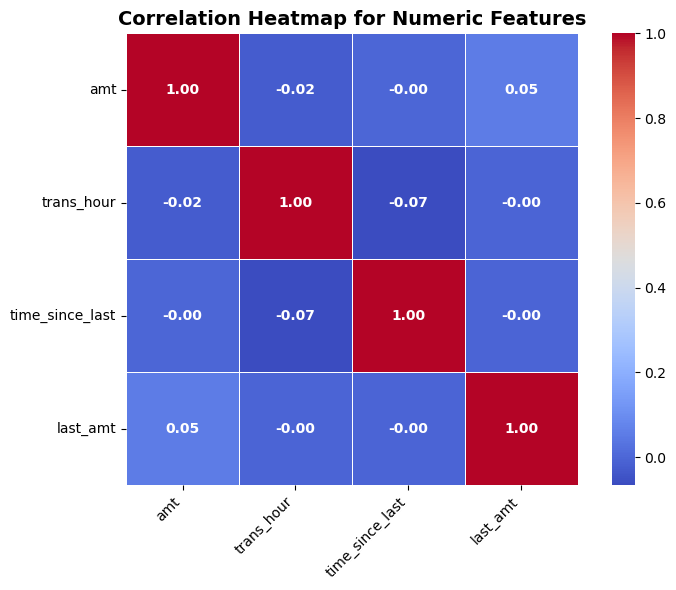

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,          # show numbers
    fmt=".2f",           # two decimal places
    cmap="coolwarm",     # color scale (red = negative, blue = positive)
    square=True,         # make each cell square-shaped
    cbar=True,           # show color bar
    linewidths=0.5,      # thin grid lines
    annot_kws={"size": 10, "weight": "bold"}  # style for numbers
)

plt.title("Correlation Heatmap for Numeric Features", fontsize=14, weight="bold")
plt.xticks(rotation=45, ha='right')  # rotate x labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# LASSO 
- To do further tests on the importance of other features precent in the data set a LASSO regression will be run 

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'trans_hour', 'trans_date',
       'time_since_last', 'last_amt'],
      dtype='object')

In [22]:
LASSO_df = df.drop(['Unnamed: 0', 'first', 'last', 'street', 'city', 'zip', 'trans_num','trans_date', 'cc_num', 'unix_time'], axis=1)

In [23]:
# Convert dob to age
# Ensure dob is datetime
LASSO_df['dob'] = pd.to_datetime(LASSO_df['dob'], errors='coerce')

# Compute age in years (using transaction time as reference)
# This ensures the age is measured *at the time of transaction*, not today
LASSO_df['age'] = (
    (LASSO_df['trans_date_trans_time'] - LASSO_df['dob'])
    .dt.days / 365.25
).round(1)

LASSO_df = LASSO_df.drop(['dob'], axis=1)

In [24]:
LASSO_df.dtypes

trans_date_trans_time    datetime64[ns]
merchant                         object
category                         object
amt                             float64
gender                           object
state                            object
lat                             float64
long                            float64
city_pop                          int64
job                              object
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
trans_hour                        int32
time_since_last                 float64
last_amt                        float64
age                             float64
dtype: object

In [25]:
LASSO_df.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'gender',
       'state', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'trans_hour', 'time_since_last', 'last_amt', 'age'],
      dtype='object')

In [26]:
LASSO_df = LASSO_df.drop(['job'],axis=1)

In [27]:
cat_cols = ['merchant', 'category', 'gender', 'state']
num_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
            'trans_hour', 'time_since_last', 'last_amt', 'age']

Train/test splits

In [28]:
# sort data to avoid leakage
LASSO_df = LASSO_df.sort_values('trans_date_trans_time').reset_index(drop=True)

# 2) Time-based splits
split_idx = int(len(LASSO_df) * 0.80)
train_df = LASSO_df.iloc[:split_idx]
test_df  = LASSO_df.iloc[split_idx:]

drop_cols = ['is_fraud', 'trans_date_trans_time']

y_train = train_df['is_fraud']
X_train = train_df[cat_cols + num_cols]

y_test = test_df['is_fraud']
X_test = test_df[cat_cols + num_cols]

Next we fit and transform our data using a pipeline - we will use a standard scaler for numbers and a one hot encoder for catagorical features

In [29]:
# Preprocessing: scale numerics + encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])


In [30]:
lasso_model = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=0.1,               # smaller C = stronger regularization
    max_iter=5000,
    random_state=42
)

# Full pipeline (preprocessing + model)
lasso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lasso_model)
])

# Fit
lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long', 'trans_hour',
                                                   'time_since_last',
                                                   'last_amt', 'age']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['merchant', 'category',
                                                   'gender', 'state'])])),
                ('model',
                 LogisticRegression(C=0.1, max_iter=5000, penalty='l1',
                                    random_state=42, solver='saga'))])

In [31]:
y_pred = lasso_pipe.predict(X_test)

# Evaluation
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[368877    251]
 [  1221    128]]

Precision: 0.3377
Recall:    0.0949

Classification Report:
              precision    recall  f1-score   support

           0     0.9967    0.9993    0.9980    369128
           1     0.3377    0.0949    0.1481      1349

    accuracy                         0.9960    370477
   macro avg     0.6672    0.5471    0.5731    370477
weighted avg     0.9943    0.9960    0.9949    370477



In [32]:
# Get model feature names
ohe = lasso_pipe.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, encoded_cat_cols])

# Get coefficients
coefs = lasso_pipe.named_steps['model'].coef_.flatten()

coef_df = pd.DataFrame({
    'feature': all_features,
    'coef': coefs
}).sort_values(by='coef', key=np.abs, ascending=False)

# Display non-zero coefficients (selected features)
selected = coef_df[coef_df['coef'] != 0]
print(f"{len(selected)} features selected out of {len(coef_df)}")
display(selected.head(15))


128 features selected out of 765


,feature,coef
714,category_travel,-6.471690
707,category_home,-3.236038
706,category_health_fitness,-3.156845
732,state_LA,-3.079485
702,category_food_dining,-2.981982
716,state_AL,-2.917631
708,category_kids_pets,-2.897436
724,state_GA,-2.884762
723,state_FL,-2.873259
741,state_NC,-2.872817


In [39]:
selected.to_csv("lasso_selected_features.csv", index=False)

# Polynomial Regression
- As the data may not fit a linear model we will try a polynomial regression
- This will be done on our smaller feature set to improve upon training time and avoid overfitting

In [33]:
from sklearn.preprocessing import PolynomialFeatures

num_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
  ('encoder', OneHotEncoder(drop='first'))  
])

cat_features = ['category']
num_features = ['amt', 'trans_hour', 'time_since_last', 'last_amt']

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="lbfgs"
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', log_reg)
])


In [34]:
# Split data again:
# sort data to avoid leakage
modeling_df2 = modeling_df2.sort_values('trans_date_trans_time').reset_index(drop=True)

# 2) Time-based split (e.g., last 20% as test)
split_idx = int(len(modeling_df2) * 0.80)
train_df = modeling_df2.iloc[:split_idx]
test_df  = modeling_df2.iloc[split_idx:]

drop_cols = ['is_fraud', 'trans_date_trans_time', 'trans_date', 'cc_num']
features = [col for col in modeling_df2.columns if col not in drop_cols]

y_train = train_df['is_fraud']
X_train = train_df[features]

y_test = test_df['is_fraud']
X_test = test_df[features]

Fit and evaluate the model

In [35]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [36]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Full classification report (includes F1 and support)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[342256  26872]
 [   148   1201]]

Precision: 0.0428
Recall:    0.8903

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9272    0.9620    369128
           1     0.0428    0.8903    0.0816      1349

    accuracy                         0.9271    370477
   macro avg     0.5212    0.9087    0.5218    370477
weighted avg     0.9961    0.9271    0.9588    370477

